In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA

In [7]:
image_dir = "DATA/"
image_size = (224, 224) # VGG16 Requirements

In [11]:
# Load Pretrained Model
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [12]:
def load_and_preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [13]:
# Load Images
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(
    image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

all_features = []

# Extract features
for img_path in image_paths:
    img = load_and_preprocess_image(img_path, image_size)
    features = model.predict(img)  # Extract features using VGG16
    features_flattened = features.flatten()  # Flatten features
    all_features.append(features_flattened)

all_features = np.array(all_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [14]:
# Optional: Reduce dimensionality using PCA
pca = PCA(n_components=50)
pca_features = pca.fit_transform(all_features)

### K-Means Clustering Implementation

In [15]:
# Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Initialize Centroid
def initialize_centroids(data, k):
    np.random.seed(42)
    random_indices = np.random.permutation(data.shape[0])
    centroids = data[random_indices[:k]]
    return centroids

# Clustering
def assign_clusters(data, centroids):
    clusters = []
    for point in data:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        closest_centroid = np.argmin(distances)
        clusters.append(closest_centroid)
    return np.array(clusters)

# Update centroids
def update_centroids(data, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = data[clusters == i]
        if len(cluster_points) > 0:
            new_centroids.append(cluster_points.mean(axis=0))
        else:            
            new_centroids.append(data[np.random.choice(data.shape[0])])
    return np.array(new_centroids)

# K-Means
def kmeans(data, k, max_iters=100, tol=1e-4):
    # Step 1: Initialize centroids
    centroids = initialize_centroids(data, k)
    
    for i in range(max_iters):
        # Step 2: Assign clusters
        clusters = assign_clusters(data, centroids)
        
        # Step 3: Update centroids
        new_centroids = update_centroids(data, clusters, k)
        
        # Step 4: Check for convergence (if centroids don't change)
        if np.all(np.abs(new_centroids - centroids) < tol):            
            break
        
        centroids = new_centroids

    return clusters, centroids


In [16]:
k = 8

labels, centroids = kmeans(pca_features, k)

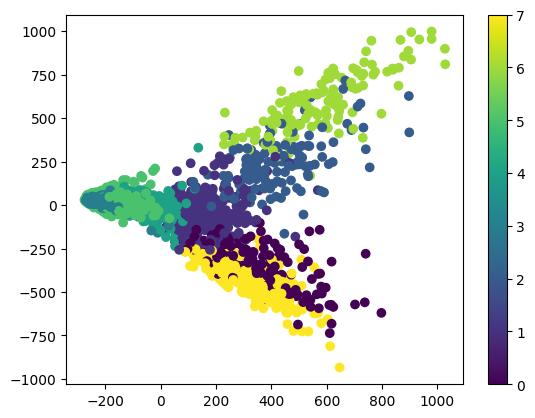

In [17]:
# Visualize clusters
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.show()

In [18]:
# Output the labels for each image
for img_path, label in zip(image_paths, labels):
    print(f"Image: {img_path}, Cluster: {label}")

Image: DATA/airport_1.jpg, Cluster: 1
Image: DATA/airport_10.jpg, Cluster: 1
Image: DATA/airport_100.jpg, Cluster: 4
Image: DATA/airport_101.jpg, Cluster: 1
Image: DATA/airport_102.jpg, Cluster: 1
Image: DATA/airport_103.jpg, Cluster: 1
Image: DATA/airport_104.jpg, Cluster: 1
Image: DATA/airport_105.jpg, Cluster: 1
Image: DATA/airport_106.jpg, Cluster: 1
Image: DATA/airport_107.jpg, Cluster: 1
Image: DATA/airport_108.jpg, Cluster: 1
Image: DATA/airport_109.jpg, Cluster: 1
Image: DATA/airport_11.jpg, Cluster: 1
Image: DATA/airport_110.jpg, Cluster: 1
Image: DATA/airport_111.jpg, Cluster: 1
Image: DATA/airport_112.jpg, Cluster: 1
Image: DATA/airport_113.jpg, Cluster: 1
Image: DATA/airport_114.jpg, Cluster: 1
Image: DATA/airport_115.jpg, Cluster: 1
Image: DATA/airport_116.jpg, Cluster: 1
Image: DATA/airport_117.jpg, Cluster: 1
Image: DATA/airport_118.jpg, Cluster: 1
Image: DATA/airport_119.jpg, Cluster: 4
Image: DATA/airport_12.jpg, Cluster: 1
Image: DATA/airport_120.jpg, Cluster: 1
Image